In [214]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import scipy.stats
import pylab
from pandas_datareader import data

In [215]:
# Tickers for analysis
tickers = ['ERII']

In [216]:
date_start = '06/01/2010'
date_end = '08/14/2020'

In [217]:
# Pull data from Yahoo Finance
df = pd.DataFrame()
df = data.DataReader(tickers, 'yahoo', date_start, date_end)
df.head(-1)

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,ERII,ERII,ERII,ERII,ERII,ERII
Date,,,,,,
2010-06-01,3.47,3.47,3.64,3.47,3.55,474900
2010-06-02,3.47,3.47,3.54,3.34,3.48,644000
2010-06-03,3.40,3.40,3.65,3.40,3.50,663800
2010-06-04,3.20,3.20,3.37,3.19,3.32,778600
2010-06-07,3.15,3.15,3.35,3.15,3.20,433700
...,...,...,...,...,...,...
2020-08-07,7.94,7.94,7.94,7.65,7.67,216600
2020-08-10,8.23,8.23,8.34,7.94,7.95,146200


In [218]:
# Daily adjusted close prices of individual asset classes
adj_close = pd.DataFrame()
adj_close = df["Adj Close"]
adj_close.fillna(0).head(-1)

Symbols,ERII
Date,
2010-06-01,3.47
2010-06-02,3.47
2010-06-03,3.40
2010-06-04,3.20
2010-06-07,3.15
...,...
2020-08-07,7.94
2020-08-10,8.23
2020-08-11,8.40


In [219]:
# Trim the dataset (if required)
adj_close = adj_close.loc["2015-01-01":, :]
adj_close.head(-1)

Symbols,ERII
Date,
2015-01-02,5.21
2015-01-05,4.87
2015-01-06,4.57
2015-01-07,4.67
2015-01-08,4.81
...,...
2020-08-07,7.94
2020-08-10,8.23
2020-08-11,8.40


 ### Initial Time-Series Plotting / Analysis

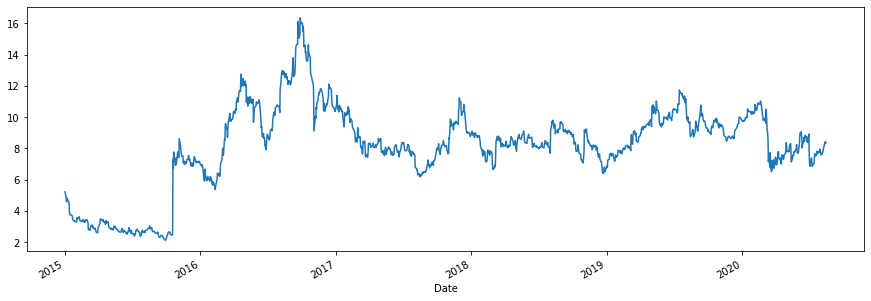

In [220]:
# Plotting closing price
adj_close.ERII.plot(kind='line',figsize=(15,5));

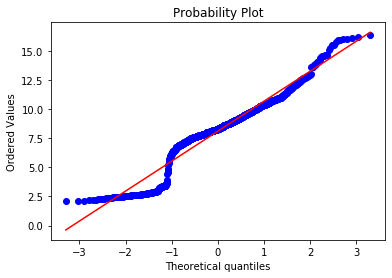

In [221]:
# Probability Plot used to infer the distribution
# If probabilities deviate from the line, it's not a normal distribution
scipy.stats.probplot(adj_close.ERII,plot=pylab);

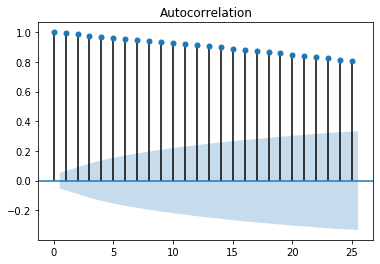

In [222]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(adj_close.ERII, lags=25);

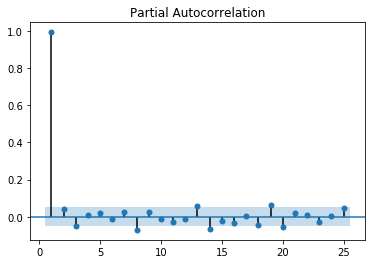

In [223]:
import statsmodels as sm
sm.graphics.tsaplots.plot_pacf(adj_close.ERII, lags=25, zero=False);

---

### Decomposition (Trend/Noise) Using a Hodrick-Prescott Filter

In [224]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(adj_close['ERII'])

In [225]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df_hp = pd.DataFrame()
df_hp['price']=adj_close.ERII
df_hp['noise']=settle_noise
df_hp['trend']=settle_trend
df_hp.head()

,price,noise,trend
Date,,,
2015-01-02,5.21,0.327520,4.882480
2015-01-05,4.87,0.084633,4.785367
2015-01-06,4.57,-0.118457,4.688458
2015-01-07,4.67,0.077989,4.592011
2015-01-08,4.81,0.313790,4.496210


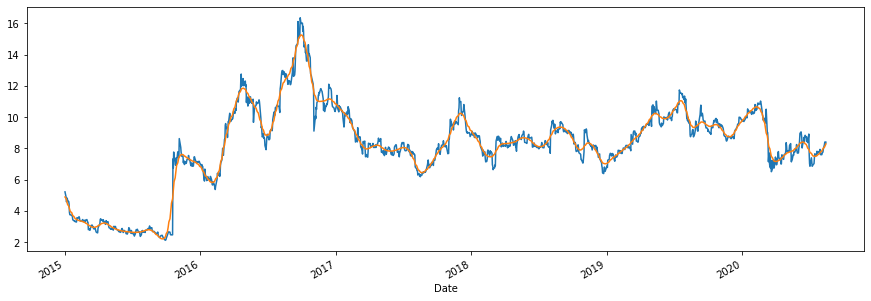

In [226]:
# Plot the Settle Price vs. the Trend
df_hp.price.plot(kind='line',figsize=(15,5));
df_hp.trend.plot(kind='line',figsize=(15,5));

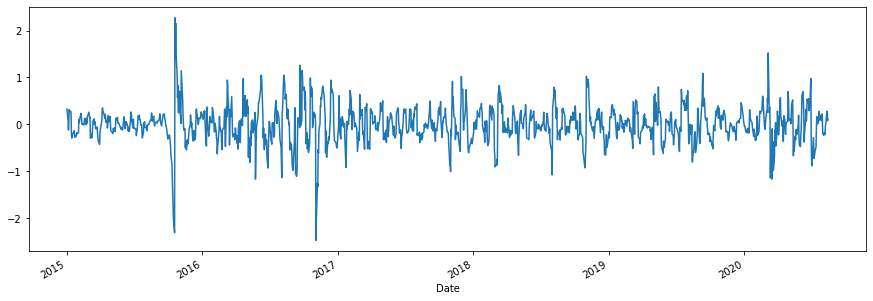

In [227]:
# Plot the ADJ Close noise
df_hp.noise.plot(kind='line',figsize=(15,5));

---

### Forecasting Returns using an ARMA Model

In [228]:
# Calculating daily returns
returns = (adj_close[["ERII"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head(-1)

Symbols,ERII
Date,
2015-01-05,-6.525915
2015-01-06,-6.160159
2015-01-07,2.188182
2015-01-08,2.997856
2015-01-09,-2.910600
...,...
2020-08-07,2.451614
2020-08-10,3.652386
2020-08-11,2.065615


In [229]:
# Import ARMA model
from statsmodels.tsa.arima_model import ARMA

In [230]:
# Create ARMA model
model = ARMA(returns.values, order=(1,1))

In [231]:
# Fit model to data
results = model.fit()

In [232]:
# Model summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1414
Model:                     ARMA(1, 1)   Log Likelihood               -4603.631
Method:                       css-mle   S.D. of innovations              6.276
Date:                Fri, 14 Aug 2020   AIC                           9215.261
Time:                        16:39:33   BIC                           9236.278
Sample:                             0   HQIC                          9223.114
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1560      0.162      0.963      0.335      -0.161       0.473
ar.L1.y       -0.6279      0.188     -3.338      0.001      -0.997      -0.259
ma.L1.y        0.5796      0.196      2.952      0.003       0.195       0.965
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5926           +0.0000j            1.5926            0.5000
MA.1           -1.7252           +0.0000j            1.7252            0.5000
-----------------------------------------------------------------------------
"""

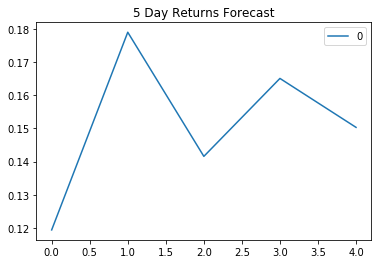

In [233]:
# Plot of 5 day returns forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast");

---

### Forecasting the ADJ Close Price using an ARIMA Model

In [234]:
from statsmodels.tsa.arima_model import ARIMA
# Estimate and ARIMA Model:
model = ARIMA(adj_close.ERII, order=(1, 1, 1))

C:\Users\erics\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\erics\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [235]:
# Fit the model
results=model.fit()

In [236]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ERII   No. Observations:                 1414
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -379.588
Method:                       css-mle   S.D. of innovations              0.316
Date:                Fri, 14 Aug 2020   AIC                            767.175
Time:                        16:39:33   BIC                            788.192
Sample:                             1   HQIC                           775.028
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0023      0.008      0.278      0.781      -0.014       0.018
ar.L1.D.ERII    -0.4411      0.227     -1.941      0.052      -0.886       0.004
ma.L1.D.ERII     0.3875      0.233      1.666      0.096      -0.068       0.843
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.2670           +0.0000j            2.2670            0.5000
MA.1           -2.5808           +0.0000j            2.5808            0.5000
-----------------------------------------------------------------------------
"""

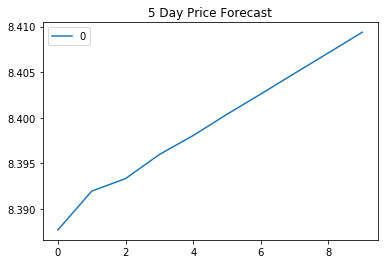

In [237]:
# Plot of the 5 day price forecast
pd.DataFrame(results.forecast(steps=10)[0]).plot(title="5 Day Price Forecast");

---

### Volatility Forecasting with GARCH

In [238]:
from arch import arch_model

In [239]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

In [240]:
# Model fit
garch_results = model.fit(disp="off")

In [241]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   ERII   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -4606.31
Distribution:                  Normal   AIC:                           9218.61
Method:            Maximum Likelihood   BIC:                           9234.38
                                        No. Observations:                 1414
Date:                Fri, Aug 14 2020   Df Residuals:                     1411
Time:                        16:39:34   Df Model:                            3
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         19.2999     12.692      1.521      0.128      [ -5.576, 44.176]
alpha[1]   1.2181e-03  2.877e-03      0.423      0.672 [-4.421e-03,6.857e-03]
beta[1]        0.5111      0.552      0.925      0.355      [ -0.572,  1.594]
=============================================================================

Covariance estimator: robust
"""

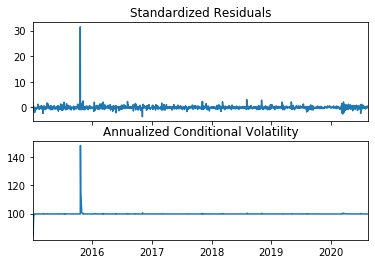

In [242]:
fig = garch_results.plot(annualize='D')

In [243]:
# Last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-08-14'

In [244]:
# 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)

In [245]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-08-14,99.746693,99.80506,99.83495,99.850261,99.858104


In [246]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-08-14
h.1,99.746693
h.2,99.805060
h.3,99.834950
h.4,99.850261
h.5,99.858104


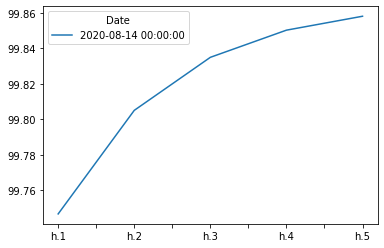

In [247]:
# Plot the final forecast
final.plot();

---